# Project 4


## Project Description

**Point 1** - Find if there is missing data, if missing datas is very small delete those customer (delete rows).

**Point 2** - Make sure there is no multicollinearity. Delete variable if necessary.

**Point 3**

- Use 3 to 5 AI-based algorithms and Logit. 
- Using 2/3 data for training and 1/3 for validation evalute their performance, for Logit use % Predicted Accuracy as Measure of accuracy.
- Show the confusion matrix for each of them.

**Point 4** - Report

- Comments on data preparation
- Multicollinearity analysis
- What factors contribute to loan defaults the most?



## Data Description

- person_age - Age
- person_income - Annual Income
- person_home_ownership - Home ownership
- person_emp_length - Employment length (in years)
- loan_intent - Loan intent
- loan_grade - Loan grade
- loan_amnt - Loan amount
- loan_int_rate - Interest rate
- loan_status - Loan status (0 is non default 1 is default)
- loan_percent_income - Percent income
- cb_person_default_on_file - Historical default
- cb_preson_cred_hist_length - Credit history length


## Used Modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import itertools
from tabulate import tabulate
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Data Visualisation

In [3]:
# Functions for data visualization
def print_results(data, title = ''):
    print(title)
    print(tabulate(data, headers = "keys", tablefmt='pretty', showindex=True))

def print_results_heatmap(data, title = '', avoid_cols = [], range_01_cols = [], inv_pattern_cols = []):
    print(title)
    styled_data = data.style
    for column in data.columns:
        if data[column].dtype == 'float64' and column not in avoid_cols:
            vmin = data[column].min()
            vmax = data[column].max()
            if column in range_01_cols:
                vmin = 0
                vmax = 1
            if column not in inv_pattern_cols:
                styled_data = styled_data.background_gradient(subset=column, cmap='RdYlGn', vmin=vmin, vmax=vmax) #Red yellow green
            else:
                styled_data = styled_data.background_gradient(subset=column, cmap='RdYlGn_r', vmin=vmin, vmax=vmax) #green yellow red

    display(styled_data)
    
def print_confusion_matrix(tp, fp, tn, fn, vmin=None, vmax=None):
    matrix = [
        [tp, fn],
        [fp, tn]
    ]
    
    labels = ["Actual Positive", "Actual Negative"]
    predictions = ["Predicted Positive", "Predicted Negative"]

    ax = plt.axes()
    sns.heatmap(matrix, annot=True, fmt="f", cmap="RdYlGn", ax=ax, vmin=vmin, vmax=vmax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticklabels(predictions)
    ax.set_yticklabels(labels)
    plt.title("Confusion Matrix")
    plt.show()

## Data Extraction

In [4]:
# Data extraction from designed excel file
def read_excel_file(file_path):
    df = pd.read_excel(file_path)
    return df

## Data Preparation

### Functions

In [5]:
def apply_mappings(df, mappings):
    for column, mapping in mappings.items():
        df[column] = df[column].replace(mapping)
    return df

# Multicollinearity analysis

def calculate_vif(predictors, data):
    X = data[predictors]
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif["VIF"].mean()


def multicollinearity_analysis(data, combinations):
   
    dfs = []
    
    # Calculate the statistics for each combination of predictors
    i = 1
    with tqdm(total=len(combinations)) as pbar:
        for combination in combinations:
            pbar.set_description(f'Combination {i}/{len(combinations)}')
            pbar.update(1)
            
            subset = data[list(combination)]
            correlation_matrix = subset.corr()
            correlation = correlation_matrix.values[np.triu_indices(len(correlation_matrix), k = 1)].mean()

            # Calculating VIF score for each combination of predictors
            vif = calculate_vif(list(combination), data)

            df = pd.DataFrame({
                'Combination': [combination],
                'Correlation': [abs(correlation)],
                'VIF': [vif]
            })
            dfs.append(df)
            i += 1

        result_df = pd.concat(dfs, ignore_index=True)

    return result_df.sort_values(by='Correlation', ascending=True)


def plot_pair_corr_heatmap(data, predictors): # Plot the pair correlation matrix heatmap
    pair_corr_matrix = data[predictors].corr()
    plt.figure(figsize=(12, 9))
    sns.heatmap(pair_corr_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
    plt.title("Pair Correlation Matrix")
    plt.show()

def combinations(el_list): # Get combination
    all_combo = set()
    for r in range(2, len(el_list) + 1):
        combinations = itertools.combinations(el_list, r)
        for combination in combinations:
            all_combo.add(tuple(sorted(combination)))
    return list(all_combo)

def standardize_data(df, columns_to_standardize):
    scaler = StandardScaler()
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    return df

### Parameters & Read Dataset

In [6]:
# Parameters
file_path = 'data.xlsx' 
dependent_var = 'loan_status'
print_row_limit = 5


# Read Dataset
data = read_excel_file(file_path)
print_results(data[:print_row_limit], 'Income Dataset Example')
print(f'INFO:\n{data.info()}\n')

Income Dataset Example
+---+------------+---------------+-----------------------+-------------------+-------------+------------+-----------+---------------+-------------+---------------------+---------------------------+----------------------------+
|   | person_age | person_income | person_home_ownership | person_emp_length | loan_intent | loan_grade | loan_amnt | loan_int_rate | loan_status | loan_percent_income | cb_person_default_on_file | cb_person_cred_hist_length |
+---+------------+---------------+-----------------------+-------------------+-------------+------------+-----------+---------------+-------------+---------------------+---------------------------+----------------------------+
| 0 |     22     |     59000     |         RENT          |       123.0       |  PERSONAL   |     D      |   35000   |     16.02     |      1      |        0.59         |             Y             |             3              |
| 1 |     21     |     9600      |          OWN          |        5.0

### Coulmns values & Missing data

In [7]:
# Find each row that contains a NaN
df_missing_values = data[data.isna().any(axis=1)]
missing_values_count = df_missing_values.shape[0]
missing_values_by_column = data.isna().sum(axis=0)

print(f'\n--> There are {missing_values_count} rows with missing values\n')
print(f'Missing values count for each dataset column:\n{missing_values_by_column}\n')

print_results(df_missing_values[:print_row_limit], f'Rows with missing values (Limit: {print_row_limit})')

# Show values in columns
avoid_cols = ['person_income','loan_amnt','loan_int_rate'] # Columns to avoid cause too many different values

for col in data.columns.tolist():
    if col not in avoid_cols:
        print(f"Values in column '{col}': \n{sorted(data[col].unique())}")



--> There are 3943 rows with missing values

Missing values count for each dataset column:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Rows with missing values (Limit: 5)
+----+------------+---------------+-----------------------+-------------------+-------------------+------------+-----------+---------------+-------------+---------------------+---------------------------+----------------------------+
|    | person_age | person_income | person_home_ownership | person_emp_length |    loan_intent    | loan_grade | loan_amnt | loan_int_rate | loan_status | loan_percent_income | cb_person_default_on_file |

### DropNaN and apply values mapping to dataset

In [8]:
mappings = {
    'person_home_ownership': {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER' : 3},
    'loan_intent': {'DEBTCONSOLIDATION' : 0, 'EDUCATION' : 1, 'HOMEIMPROVEMENT' : 2, 'MEDICAL' : 3, 'PERSONAL' : 4, 'VENTURE' : 5},
    'loan_grade': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6},
    'cb_person_default_on_file': {'N': 0, 'Y': 1}
}

# Drop NaN Values

# Replacing any empty string with NaN.
data = data.replace('', np.nan)

print(f'\n--> NaN Values dropped from data.\n\nData Initial Size: {data.shape[0]}\nMissing values: {missing_values_count}')
data = data.dropna()
print(f'New dataset size: {data.shape[0]}')

# Apply mapping
print(f'\n--> Mapping specified applied')
data = apply_mappings(data, mappings)
print_results(data[:20], '\nDataset without NaN and applied mapping (Example)')


--> NaN Values dropped from data.

Data Initial Size: 32581
Missing values: 3943
New dataset size: 28638

--> Mapping specified applied

Dataset without NaN and applied mapping (Example)
+----+------------+---------------+-----------------------+-------------------+-------------+------------+-----------+---------------+-------------+---------------------+---------------------------+----------------------------+
|    | person_age | person_income | person_home_ownership | person_emp_length | loan_intent | loan_grade | loan_amnt | loan_int_rate | loan_status | loan_percent_income | cb_person_default_on_file | cb_person_cred_hist_length |
+----+------------+---------------+-----------------------+-------------------+-------------+------------+-----------+---------------+-------------+---------------------+---------------------------+----------------------------+
| 0  |    22.0    |    59000.0    |          0.0          |       123.0       |     4.0     |    3.0     |  35000.0  |     16.02

/tmp/ipykernel_36684/3322234810.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(mapping)


### Standardize data

In [9]:
#Standardize Data
cols_to_standardize = [ 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length','person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
data = standardize_data(data, cols_to_standardize)
print_results(data[:5], f'Standardized dataset')

# show dependent and indipendent variables

independent_vars = data.columns.tolist()
independent_vars.remove(dependent_var)
print(f'\nColumns:{data.columns.tolist()}\n')
print(f'--> Dependent variable : {dependent_var}\n')
print(f'--> Indipendent variables: {independent_vars}\n')

Standardized dataset
+---+----------------------+-----------------------+-----------------------+----------------------+---------------------+----------------------+---------------------+----------------------+-------------+---------------------+---------------------------+----------------------------+
|   |      person_age      |     person_income     | person_home_ownership |  person_emp_length   |     loan_intent     |      loan_grade      |      loan_amnt      |    loan_int_rate     | loan_status | loan_percent_income | cb_person_default_on_file | cb_person_cred_hist_length |
+---+----------------------+-----------------------+-----------------------+----------------------+---------------------+----------------------+---------------------+----------------------+-------------+---------------------+---------------------------+----------------------------+
| 0 | -0.9075935673909893  | -0.12267384942878225  |  -0.9465782700620791  |  28.453432987970363  | 0.8490521469924948  |  1.51345

### Multicollinearity

In [10]:
independent_vars_combo = combinations(independent_vars)
print(f'Number of variables: {len(independent_vars)} => Number of subsets: {len(independent_vars_combo)}')

independent_vars_combo_scores = multicollinearity_analysis(data, independent_vars_combo)
independent_vars_combo_scores['Score'] = independent_vars_combo_scores['VIF'] + independent_vars_combo_scores['Correlation']

Number of variables: 11 => Number of subsets: 2036


Combination 2036/2036: 100%|██████████| 2036/2036 [01:32<00:00, 22.01it/s]


#### Show multicollinearity results

In [11]:
# Print top n combination by correlation coefficent

topn = 100
print_results_heatmap(independent_vars_combo_scores[:topn].sort_values(by = ['Score'], ascending = True).reset_index(drop=True), f'Chosen indipendent variable combination - Top-{topn} by Correlation')

selected_combo = []
print_results(independent_vars_combo_scores.loc[selected_combo].sort_values(by = ['Score']), 'Selected Combinations:')

Chosen indipendent variable combination - Top-100 by Correlation


,Combination,Correlation,VIF,Score
0,"('loan_intent', 'person_home_ownership')",0.000068,1.000000,1.000068
1,"('loan_grade', 'loan_intent', 'person_income')",0.000199,1.000019,1.000218
2,"('loan_intent', 'loan_percent_income')",0.000436,1.000000,1.000436
3,"('loan_int_rate', 'loan_intent', 'person_income')",0.000457,1.000010,1.000467
4,"('cb_person_default_on_file', 'loan_intent', 'person_income')",0.000871,1.000013,1.000884
5,"('loan_int_rate', 'person_income')",0.001381,1.000002,1.001383
6,"('loan_grade', 'person_income')",0.001392,1.000002,1.001394
7,"('cb_person_default_on_file', 'loan_intent')",0.002444,1.000006,1.002450
8,"('loan_int_rate', 'loan_intent')",0.002532,1.000006,1.002538
9,"('loan_intent', 'person_income')",0.002541,1.000006,1.002547


Selected Combinations:
+-------------+-------------+-----+-------+
| Combination | Correlation | VIF | Score |
+-------------+-------------+-----+-------+
+-------------+-------------+-----+-------+


#### Pair correlation matrix

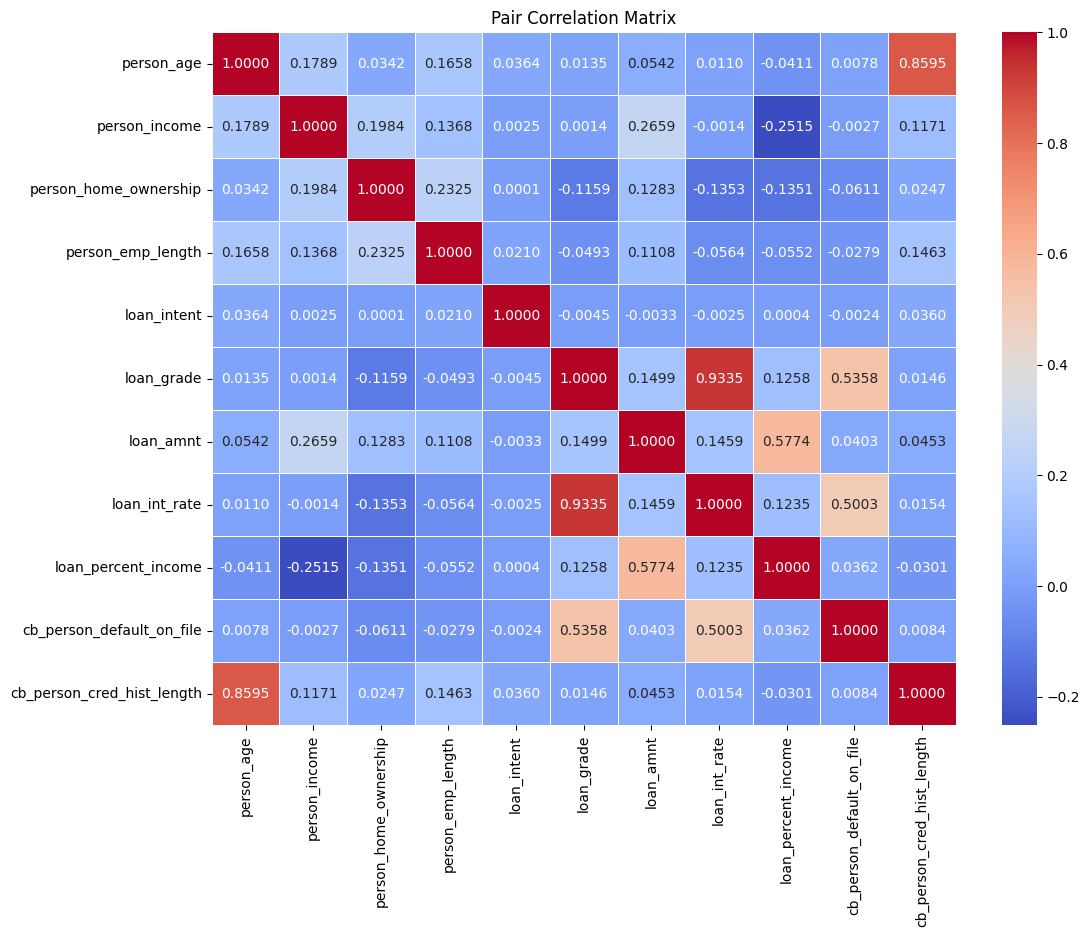

In [12]:
# Print pair correlation heatmap
plot_pair_corr_heatmap(data, independent_vars)

## Analysis

### Models measures

In [13]:
def calculate_measures(y_true, y_pred, y_prob):
    measures = {}
    
    # Accuracy
    measures['Accuracy'] = accuracy_score(y_true, y_pred)
    # Precision
    measures['Precision'] = precision_score(y_true, y_pred, zero_division = 0)
    # Recall
    measures['Recall'] = recall_score(y_true, y_pred)
    # AUROC
    measures['AUROC'] = roc_auc_score(y_true, y_prob)
    
    return measures

### Models

#### Logit

In [14]:
def run_logit(x_train, y_train, x_test, y_test, all_vars):
    logit_model = sm.Logit(y_train, x_train)
    logit_results = logit_model.fit(disp=False)
    logit_preds = logit_results.predict(x_test)
    logit_binary_preds = logit_preds >= 0.5
    
    measures = calculate_measures(y_test, logit_binary_preds, logit_preds)
    
    coeffs = {var: logit_results.params.get(var, 0) for var in all_vars}
    cm = confusion_matrix(y_test, logit_binary_preds)
    tn, fp, fn, tp = cm.ravel()
    
    output = {
        'Model': 'Logit',
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        **measures,
        **coeffs
    }
    
    return logit_model, output

#### Random forest

In [15]:
def run_random_forest(x_train, y_train, x_test, y_test, all_vars, indep_var):
    rf_model = RandomForestClassifier()
    rf_model.fit(x_train, y_train)
    rf_preds = rf_model.predict_proba(x_test)[:, 1]
    rf_binary_preds = rf_model.predict(x_test)
    
    measures = calculate_measures(y_test, rf_binary_preds, rf_preds)
    
    cm = confusion_matrix(y_test, rf_binary_preds)
    tn, fp, fn, tp = cm.ravel()
    
    feature_importances = {var: imp for var, imp in zip(indep_var, rf_model.feature_importances_[0:])}

    output = {
        'Model': 'Random Forest',
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        **measures,
        **{var: feature_importances.get(var, 0) for i, var in enumerate(all_vars)}    }
    
    return rf_model, output

#### Gradient Boosting

In [16]:
def run_gradient_boosting(x_train, y_train, x_test, y_test, all_vars, indep_var):
    gb_model = GradientBoostingClassifier(n_estimators = 100, max_depth = 3)
    gb_model.fit(x_train, y_train)
    gb_preds = gb_model.predict_proba(x_test)[:, 1]
    gb_binary_preds = gb_model.predict(x_test)
    
    measures = calculate_measures(y_test, gb_binary_preds, gb_preds)
    
    cm = confusion_matrix(y_test, gb_binary_preds)
    tn, fp, fn, tp = cm.ravel()
    
    feature_importances = {var: imp for var, imp in zip(indep_var, gb_model.feature_importances_[0:])}

    output = {
        'Model': 'Gradient Boosting',
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        **measures,
        **{var: feature_importances.get(var, 0) for i, var in enumerate(all_vars)}   
    }
    
    return gb_model, output

#### Neural Network

In [17]:
def run_neural_network(x_train, y_train, x_test, y_test, all_vars, indep_var):
    nn_model = MLPClassifier(max_iter = 300)
    nn_model.fit(x_train, y_train)
    nn_preds = nn_model.predict_proba(x_test)[:, 1]
    nn_binary_preds = nn_model.predict(x_test)
    
    measures = calculate_measures(y_test, nn_binary_preds, nn_preds)
    
    cm = confusion_matrix(y_test, nn_binary_preds)
    tn, fp, fn, tp = cm.ravel()
    coeff = {var: coef for var, coef in zip(indep_var, nn_model.coefs_[1].tolist())}

    output = {
        'Model': 'Neural Network',
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        **measures,
        **coeff
    }
    
    return nn_model, output

#### KNN

In [18]:
def run_knn(x_train, y_train, x_test, y_test, all_vars):
    knn_model = KNeighborsClassifier()
    knn_model.fit(x_train, y_train)
    knn_preds = knn_model.predict_proba(x_test)[:, 1]
    knn_binary_preds = knn_model.predict(x_test)
    
    measures = calculate_measures(y_test, knn_binary_preds, knn_preds)
    
    cm = confusion_matrix(y_test, knn_binary_preds)
    tn, fp, fn, tp = cm.ravel()
    
    output = {
        'Model': 'K-Nearest Neighbors',
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        **measures,
        **{var: 0 for var in all_vars}  # KNN does not provide coefficients
    }
    
    return knn_model, output

### Execute models

In [19]:
import os

def save_model(model, filename):
    model_name, subdir = filename.split('-')
    directory = "models/" + subdir 
    model_file = model_name + '.pkl'
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    file_path = os.path.join(directory, model_file)
        
    if not os.path.isfile(file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(model, f)

def run_models(data, dep_var, indep_vars, iter = 3):
    print(f'RUN MODELS\nDependent variable: {dep_var}\n')
    total_iterations = len(indep_vars['Combination']) * iter
    print(f'Total iteration to perform: {total_iterations}')
    
    all_vars = list(set([var for combination in indep_vars['Combination'] for var in combination]))                            
    result_df = pd.DataFrame(columns = ['Combination', 'Combination_ID', 'Model', 'Iteration', 'TP', 'FP','TN', 'FN', 'AUROC', 'Accuracy', 'Precision', 'Recall'] + all_vars)
    
    k = 1    
    with tqdm(total=total_iterations) as pbar:
        for idf, indep_var in enumerate(indep_vars['Combination']):

            indep_var_corr = indep_vars.loc[indep_vars['Combination'] == indep_var]['Correlation']
            indep_var_vif = indep_vars.loc[indep_vars['Combination'] == indep_var]['VIF']
            indep_var_score = indep_vars.loc[indep_vars['Combination'] == indep_var]['Score']
            
            for i in range(iter):            

                row = {
                            'Combination_ID': idf,
                            'Combination': [indep_var], 
                            'Iteration': i+1,
                            'C_Corr': indep_var_corr,
                            'C_VIF': indep_var_vif,
                            'C_Score': indep_var_score
                }

                train, test = train_test_split(data, test_size=0.33, shuffle = True) # Out of sample analysis

                # Dependent variable
                y_train = train[dep_var]
                y_test = test[dep_var]

                # Used Predictor - Indipendent Variables
                x_train = train[list(indep_var)]
                x_test = test[list(indep_var)]


                model_1, score_1 = run_logit(x_train, y_train, x_test, y_test, all_vars)
                row.update(score_1)
                result_df = pd.concat([result_df, pd.DataFrame(row)], ignore_index = True)
                save_model(model_1, 'Logit-' + str(indep_var))

                model_2, score_2 = run_random_forest(x_train, y_train, x_test, y_test, all_vars, list(indep_var))
                row.update(score_2)
                result_df = pd.concat([result_df, pd.DataFrame(row)], ignore_index=True)
                save_model(model_2, 'RandomForest-' + str(indep_var))

                model_3, score_3 = run_gradient_boosting(x_train, y_train, x_test, y_test, all_vars, list(indep_var))
                row.update(score_3)
                result_df = pd.concat([result_df, pd.DataFrame(row)], ignore_index=True)
                save_model(model_3, 'GradientBoosting-' + str(indep_var))

                model_4, score_4 = run_neural_network(x_train, y_train, x_test, y_test, all_vars, list(indep_var))
                row.update(score_4)
                result_df = pd.concat([result_df, pd.DataFrame(row)], ignore_index=True)
                save_model(model_4, 'NN-' + str(indep_var))

                model_5, score_5 = run_knn(x_train, y_train, x_test, y_test, all_vars)
                row.update(score_5)
                result_df = pd.concat([result_df, pd.DataFrame(row)], ignore_index=True)
                save_model(model_5, 'KNN-' + str(indep_var))
                
                pbar.update(1)
                pbar.set_description(f'Step : {k}/{total_iterations}')
                k += 1

    float_cols = ['TP', 'FP','TN', 'FN', 'AUROC', 'Accuracy', 'Precision', 'Recall', 'C_Corr', 'C_VIF', 'C_Score'] + all_vars
    int_cols = ['Combination_ID','Iteration']
    result_df[float_cols] = result_df[float_cols].astype('float')
    result_df[int_cols] = result_df[int_cols].astype('int')    
    pbar.close()

    return result_df

## Build result

### Evaluate Combinations

In [20]:
combinations_scores = ['Score'] # Order the combinations by correlation
row_limit = 100 # Number of combination to show
ascending = True # true = top-score combination, False = lowest score combinations

print_results(independent_vars_combo_scores.sort_values(by = combinations_scores, ascending = ascending)[:row_limit])


+------+----------------------------------------------------------------------------------------------------------------------------+------------------------+--------------------+--------------------+
|      |                                                        Combination                                                         |      Correlation       |        VIF         |       Score        |
+------+----------------------------------------------------------------------------------------------------------------------------+------------------------+--------------------+--------------------+
| 393  |                                          ('loan_intent', 'person_home_ownership')                                          | 6.814085226904503e-05  | 1.0000000046431767 | 1.0000681454954459 |
| 1436 |                                       ('loan_grade', 'loan_intent', 'person_income')                                       | 0.00019857761877206467 | 1.0000193035285687 | 1.0002178811473

### Choose combination/s

In [21]:
# Specify the ids of chosen combination (see previous step)
chosen_combo_id = [215, 1617, 669, 1833, 1634, 1010] 

# Combinations in input to the models
chosen_independent_vars = independent_vars_combo_scores.sort_values(by = combinations_scores, ascending = ascending).loc[chosen_combo_id]

print_results(chosen_independent_vars, 'Chosen independent variables')

Chosen independent variables
+------+---------------------------------------------------------------------------------------------------------------------------------------+----------------------+--------------------+--------------------+
|      |                                                              Combination                                                              |     Correlation      |        VIF         |       Score        |
+------+---------------------------------------------------------------------------------------------------------------------------------------+----------------------+--------------------+--------------------+
| 215  |                             ('loan_grade', 'loan_intent', 'loan_percent_income', 'person_home_ownership')                             | 0.021552703611303365 | 1.021766665769169  | 1.0433193693804725 |
| 1617 |                 ('loan_grade', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership')      

### Run Models

In [22]:
# Run models with selected combination/s
result = run_models(data, dependent_var, chosen_independent_vars)

RUN MODELS
Dependent variable: loan_status

Total iteration to perform: 18


Step : 1/18:   6%|███▉                                                                  | 1/18 [00:16<04:36, 16.25s/it]C:\Users\lucaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Step : 18/18: 100%|████████████████████████████████████████████████████████████████████| 18/18 [03:54<00:00, 13.03s/it]


### Standard result visualisation

In [28]:
r0 = result.copy()

# Show used Combination - ID
print_results(result[['Combination', 'Combination_ID']].drop_duplicates(subset=['Combination', 'Combination_ID']).sort_values(by = 'Combination_ID').set_index('Combination_ID'), 'Used Combinations reference')

# Build overall score
scores_label = ['Accuracy','AUROC']
result['Score'] = r0[scores_label].sum(axis = 1)

# Data aggregated for combination - Not showing each iteration
result_grouped = r0.groupby(['Combination', 'Combination_ID', 'Model'], as_index = False).mean(numeric_only = False)
result_grouped['Iteration'] = 'AVG'

# Print result
GnYlRd_cols = ['C_Corr','C_VIF','C_Score']
print_results_heatmap(result_grouped.sort_values(by = 'Combination_ID'), 'Models results', inv_pattern_cols = GnYlRd_cols )


Used Combinations reference
+----------------+---------------------------------------------------------------------------------------------------------------------------------------+
| Combination_ID |                                                              Combination                                                              |
+----------------+---------------------------------------------------------------------------------------------------------------------------------------+
|       0        |                             ('loan_grade', 'loan_intent', 'loan_percent_income', 'person_home_ownership')                             |
|       1        |                 ('loan_grade', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership')                  |
|       2        |         ('cb_person_cred_hist_length', 'cb_person_default_on_file', 'loan_int_rate', 'loan_intent', 'person_home_ownership')          |
|       3        |                        

,Combination,Combination_ID,Model,Iteration,TP,FP,TN,FN,AUROC,Accuracy,Precision,Recall,loan_intent,loan_amnt,loan_int_rate,person_age,loan_percent_income,person_home_ownership,cb_person_cred_hist_length,cb_person_default_on_file,person_emp_length,loan_grade,C_Corr,C_VIF,C_Score,Score
29,"('loan_grade', 'loan_intent', 'loan_percent_income', 'person_home_ownership')",0,Random Forest,AVG,1274.666667,232.333333,7157.333333,786.666667,0.855617,0.892181,0.845833,0.618595,0.119095,0.000000,0.000000,0.000000,0.440541,0.161821,0.000000,0.000000,0.000000,0.278543,0.021553,1.021767,1.043319,1.747797
27,"('loan_grade', 'loan_intent', 'loan_percent_income', 'person_home_ownership')",0,Logit,AVG,1739.000000,2545.000000,4844.666667,322.333333,0.841272,0.696611,0.405912,0.843725,-0.127094,0.000000,0.000000,0.000000,0.667336,-0.259149,0.000000,0.000000,0.000000,0.657271,0.021553,1.021767,1.043319,1.537883
26,"('loan_grade', 'loan_intent', 'loan_percent_income', 'person_home_ownership')",0,K-Nearest Neighbors,AVG,1270.000000,227.333333,7162.333333,791.333333,0.842844,0.892216,0.848242,0.616278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021553,1.021767,1.043319,1.735060
25,"('loan_grade', 'loan_intent', 'loan_percent_income', 'person_home_ownership')",0,Gradient Boosting,AVG,1298.000000,193.000000,7196.666667,763.333333,0.884230,0.898811,0.870627,0.629962,0.072927,0.000000,0.000000,0.000000,0.371593,0.217144,0.000000,0.000000,0.000000,0.338336,0.021553,1.021767,1.043319,1.783042
28,"('loan_grade', 'loan_intent', 'loan_percent_income', 'person_home_ownership')",0,Neural Network,AVG,1309.000000,225.333333,7164.333333,752.333333,0.884505,0.896554,0.854544,0.634814,0.377839,0.000000,0.000000,0.000000,0.229267,2.501880,0.000000,0.000000,0.000000,3.800994,0.021553,1.021767,1.043319,1.781059
24,"('loan_grade', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership')",1,Random Forest,AVG,1255.000000,344.333333,7088.666667,763.000000,0.866543,0.882834,0.784688,0.621898,0.000000,0.000000,0.256291,0.000000,0.364851,0.110831,0.000000,0.000000,0.140098,0.127929,0.086804,3.759129,3.845933,1.749378
23,"('loan_grade', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership')",1,Neural Network,AVG,1142.000000,227.333333,7205.666667,876.000000,0.873987,0.883258,0.835158,0.565900,0.000000,0.000000,0.307669,0.000000,-0.013466,0.245139,0.000000,0.000000,0.172648,-0.128705,0.086804,3.759129,3.845933,1.757244
22,"('loan_grade', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership')",1,Logit,AVG,1675.000000,2468.666667,4964.333333,343.000000,0.835325,0.702501,0.404311,0.830027,0.000000,0.000000,-0.420169,0.000000,0.671111,-0.260797,0.000000,0.000000,-0.044305,1.061978,0.086804,3.759129,3.845933,1.537825
21,"('loan_grade', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership')",1,K-Nearest Neighbors,AVG,1164.000000,311.333333,7121.666667,854.000000,0.843393,0.876697,0.789042,0.576801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086804,3.759129,3.845933,1.720091
20,"('loan_grade', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership')",1,Gradient Boosting,AVG,1156.666667,238.666667,7194.333333,861.333333,0.872917,0.883610,0.829678,0.573170,0.000000,0.000000,0.030456,0.000000,0.387289,0.220439,0.000000,0.000000,0.044537,0.317279,0.086804,3.759129,3.845933,1.756527


### Data Aggregations

Models results


,TP,FP,TN,FN,AUROC,Accuracy,Precision,Recall,loan_intent,loan_amnt,loan_int_rate,person_age,loan_percent_income,person_home_ownership,cb_person_cred_hist_length,cb_person_default_on_file,person_emp_length,loan_grade
Model,,,,,,,,,,,,,,,,,,
Gradient Boosting,1100.166667,295.888889,7108.055556,946.888889,0.845537,0.868503,0.793174,0.538515,0.087076,0.018244,0.133023,0.005670,0.280898,0.107175,0.001800,0.000351,0.033653,0.332110
Neural Network,1051.833333,299.111111,7104.833333,995.222222,0.841499,0.863048,0.780482,0.514621,0.132593,-0.018104,-0.029318,-0.005316,0.021927,0.476901,0.143244,0.086823,0.038663,0.603829
Random Forest,1124.833333,453.222222,6950.722222,922.222222,0.823585,0.854466,0.711740,0.550478,0.076986,0.037318,0.287015,0.054876,0.248933,0.058424,0.029063,0.006552,0.067585,0.133247
K-Nearest Neighbors,1050.222222,407.222222,6996.722222,996.833333,0.797528,0.851438,0.717759,0.513846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Logit,1637.888889,2557.555556,4846.388889,409.166667,0.809659,0.686094,0.391361,0.800591,-0.080928,-0.071256,-0.155162,-0.005188,0.498974,-0.138671,-0.003710,-0.004876,-0.043357,0.810317


,Accuracy,Precision,AUROC,Recall
Model,,,,
Gradient Boosting,0.868503,0.793174,0.845537,0.538515


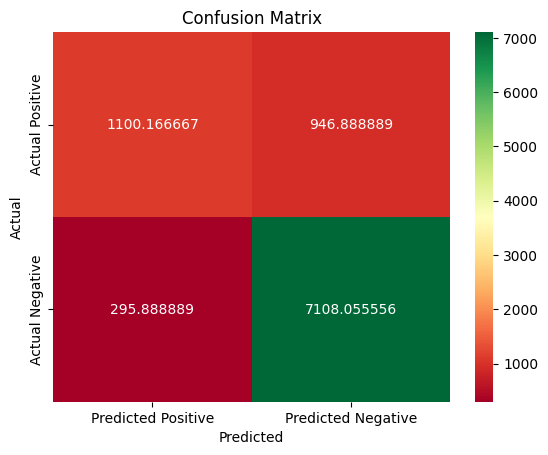

,Accuracy,Precision,AUROC,Recall
Model,,,,
Neural Network,0.863048,0.780482,0.841499,0.514621


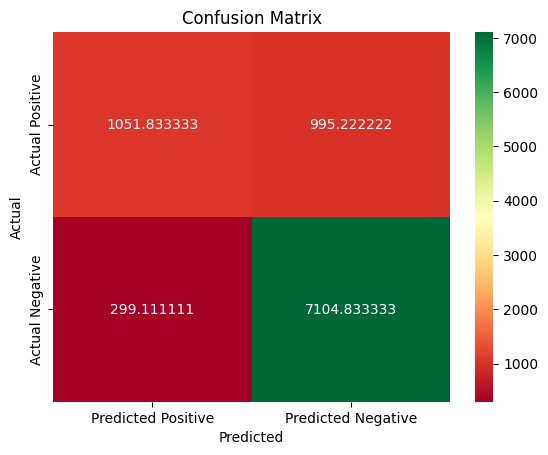

,Accuracy,Precision,AUROC,Recall
Model,,,,
Random Forest,0.854466,0.711740,0.823585,0.550478


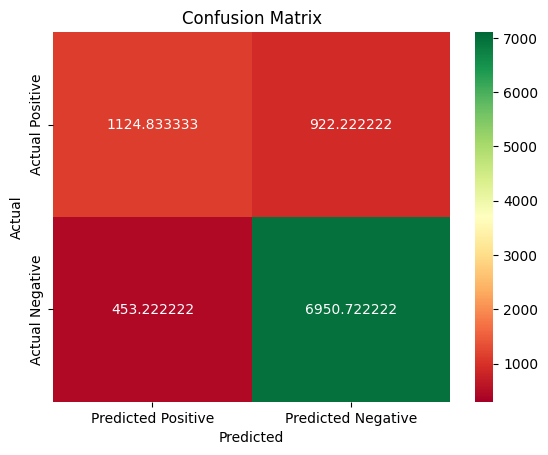

,Accuracy,Precision,AUROC,Recall
Model,,,,
K-Nearest Neighbors,0.851438,0.717759,0.797528,0.513846


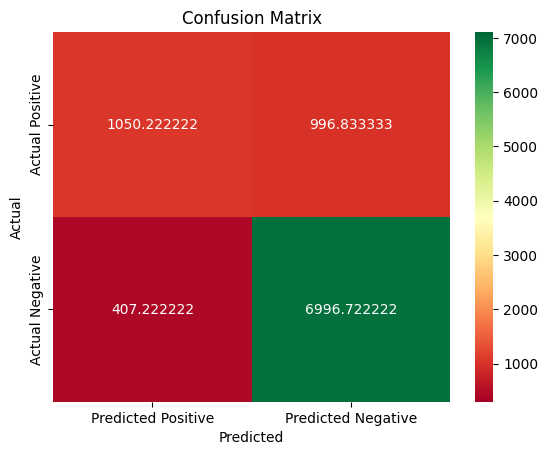

,Accuracy,Precision,AUROC,Recall
Model,,,,
Logit,0.686094,0.391361,0.809659,0.800591


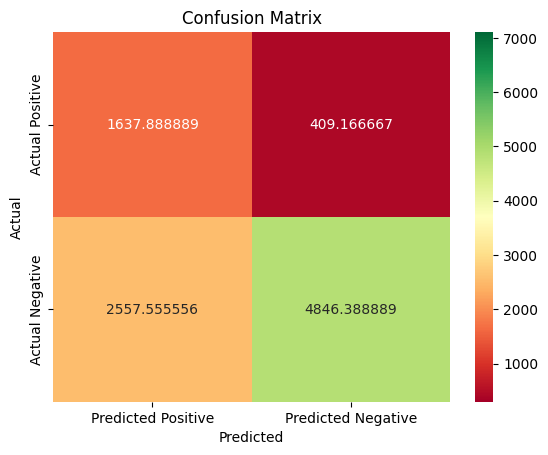

In [24]:
# Print data aggregated -------------------------------------------------------------------------------------------------------------------------------------------------- 1

tmp = result.copy()
round_factor = 10

# Columns for independent variables contribution and confusion amtrix
indep_vars_cols = ['person_age', 'person_income', 'person_home_ownership','person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt','loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']
conf_matrix_cols = ['TP','FP','TN','FN']
drop_cols = ['Combination_ID','Iteration','C_Corr', 'C_VIF', 'C_Score','Score'] # Columns not to show

group_by_cols_1 = ['Combination', 'Model', 'Combination_ID'] # Columns to use for groupby - Grouping the iteration for each model
r1 = tmp.groupby(group_by_cols_1, as_index = False).mean(numeric_only = True).round(round_factor)

group_by_cols_2 = ['Model']
r2 = r1.groupby(group_by_cols_2, as_index = False).mean(numeric_only = True).round(round_factor)

r3 = r2.drop(drop_cols, axis = 1) # Drop columns

# Columns to color: color between 0 and 1 and inverted pattern
range01_cols = ['Accuracy','Precision','AUROC','Recall','F1-Score']
sort_cols = ['Accuracy','AUROC','Precision','Recall']
avoid_cols = []

r4 = r3.sort_values(by = sort_cols, ascending = False).set_index('Model')
print_results_heatmap(r4, 'Models results', avoid_cols, range01_cols, GnYlRd_cols)
print_results_heatmap(r4, 'Models results', avoid_cols, range01_cols, GnYlRd_cols)

vmax = r4[conf_matrix_cols].max(axis = 1).max()
vmin = r4[conf_matrix_cols].min(axis = 1).min()

for i in r4.index.tolist():
    print_results_heatmap(r4.loc[r4.index == i][['Accuracy','Precision','AUROC','Recall']] ,range_01_cols = range01_cols )
    print_confusion_matrix(r4.loc[i]['TP'], r4.loc[i]['FP'], r4.loc[i]['TN'], r4.loc[i]['FN'], vmin, vmax)